<u>**ПЛАН РАБОТЫ**</u>:<br>

1. Ознакомление с данными
2. Предобработка данных
3. Подготовка к моделированию<br>
    3.1. подготовка данных перед пйплайном<br>
    3.2. сборка пайплайна<br>
    3.3. разделение выборок<br>
4. Анализ моделей <br>
    4.1. оценка производительности<br>
    4.2. настройка гиперпараметров<br>
    4.3. валидация<br>
    4.4. тестирование<br>
5. выводы

In [1]:
!pip install -q optuna
!pip install -q phik

In [2]:
# импортируем необходимые библиотеки

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

import phik

import re
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

from scipy.sparse import csr_matrix

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.model_selection import (
    train_test_split,
    cross_val_score
)

from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler
)
import optuna

import datetime as dt
import time

RANDOM_STATE = 42

# убираем предупреждения Pandas Future warning 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [21]:
# напишем функции

def data_boxplot (df, column, title):
    
    fig, (ax_box, ax_hist) = plt.subplots(
        2, sharex=True, 
        gridspec_kw={"height_ratios": (.15, .85)},
        figsize=(8, 6)
    )

    sns.boxplot(x=df[column], ax=ax_box)
    sns.histplot(x=df[column], bins=30, kde=True, stat='density', ax=ax_hist)
    
    fig.suptitle(f"{title} {column}", fontsize=16)
    
    ax_box.set(yticks=[])
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    plt.xticks(rotation=45)
    
    plt.show()
    
    q1 = df[column].quantile(0.25).round(1)
    q3 = df[column].quantile(0.75).round(1)
    IQR = q3 - q1
    
    print(f"медиана: {df[column].median()} \n"
          f"среднее: {df[column].mean().round(1)} \n"
          f"min: {df[column].min()} \n"
          f"max: {df[column].max()} \n"
          f"верхний порог выбросов: {(q3 + 1.5 * IQR).round(2)} \n"
          f"нижний порог выбросов: {(q1 - 1.5 * IQR).round(2)} \n"
          f"Q1: {q1} \n"
          f"Q3: {q3}"
         )
    
def barplot_top10 (df, column, df_name='df'):
   
    counts = df[column].value_counts().head(10)
    plot_df = counts.reset_index()
    plot_df.columns = [column, 'count']
        
    norm = plt.Normalize(plot_df['count'].min(), plot_df['count'].max())
    colors = plt.cm.Greens(norm(plot_df['count']))    
    
    sns.barplot(data=plot_df, 
                y=column, 
                x='count', 
                palette=colors.tolist(), 
                edgecolor='darkgreen', 
                linewidth=1.5)
    
    plt.title(f"Рапределение по признаку {column} в {df_name} \n", fontsize=16)
    plt.xlabel('Количество', fontsize=14)
    plt.show()
    
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_filtered

def apply_remove_outliers_iqr(df):
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    for column in numeric_columns:
        df = remove_outliers_iqr(df, column)
    return df

## Ознакомление с данными

In [4]:
try:
    autos = pd.read_csv('D:\docs\DS\\autos.csv')
except:
    autos = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')
    
autos.info()
autos.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
autos.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


1. признаки, не представляющие ценность для нашего исследования:
* NumberOfPictures,
* PostalCode, 
* LastSeen , 
* DateCreated, 
* DateCrawled <br>
&mdash; можно их отсечь.

2. `RegistrationMonth`&mdash; избыточная информация, нам будет достаточно столбца `RegistrationYear`
3. в датасете присутствуют пропуски, нужно будет их устранить.

что необходимо выполнить на этапе подготовки данных:
* задать стиличтически корректные названия признаков;
* проверить на дубликаты;
* проверить на пропуски и выбросы;
* выбрать признаки для построения модели.

## Предобработка данных

In [6]:
# сначала займёмся названием признаков

autos.columns = (
    autos.columns
    .str.strip()
    .str.replace(r'([a-z])([A-Z])', r'\1_\2', regex=True)
    .str.lower()
)

print(autos.columns)

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')


проверим датасет на наличие полных дубликатов:

In [8]:
sum(autos.duplicated())

4

In [9]:
autos = autos.drop_duplicates()

autos.info()

sum(autos.duplicated())

<class 'pandas.core.frame.DataFrame'>
Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354365 non-null  object
 1   price               354365 non-null  int64 
 2   vehicle_type        316875 non-null  object
 3   registration_year   354365 non-null  int64 
 4   gearbox             334532 non-null  object
 5   power               354365 non-null  int64 
 6   model               334660 non-null  object
 7   kilometer           354365 non-null  int64 
 8   registration_month  354365 non-null  int64 
 9   fuel_type           321470 non-null  object
 10  brand               354365 non-null  object
 11  repaired            283211 non-null  object
 12  date_created        354365 non-null  object
 13  number_of_pictures  354365 non-null  int64 
 14  postal_code         354365 non-null  int64 
 15  last_seen           354365 non-null  object
dtypes: int6

0

In [10]:
# посчитаем количество пропусков для кождого столбца:
autos.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

In [11]:
print(f"Уникальные значения vehicle_type:\n{autos['vehicle_type'].value_counts()} \n\n"
      f"Уникальные значения gearbox:\n{autos['gearbox'].value_counts()} \n\n"
      f"Уникальные значения model:\n{autos['model'].value_counts()} \n\n"
      f"Уникальные значения fuel_type:\n{autos['fuel_type'].value_counts()} \n\n"
      f"Уникальные значения repaired:\n{autos['repaired'].value_counts()} "
     )

Уникальные значения vehicle_type:
vehicle_type
sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: count, dtype: int64 

Уникальные значения gearbox:
gearbox
manual    268249
auto       66283
Name: count, dtype: int64 

Уникальные значения model:
model
golf                  29232
other                 24420
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: count, Length: 250, dtype: int64 

Уникальные значения fuel_type:
fuel_type
petrol      216349
gasoline     98719
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: count, dtype: int64 

Уникальные значения repaired:
repaired
no     247158
yes     36053
Name: c

в некоторых признаках уже есть значение `other`, которое мы можем использовать для заполненя пропусков, в остальных признаках заполним пропуски с помощью заглушки `unknown`.

однако перед ием тем как приступить к этому шагу, проверим на неявные дубликаты значения признака `model`:

In [12]:
autos = autos.loc[~autos['model'].isna()]
autos['model'].unique()

array(['golf', 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox', 'ma

действительно, в названиях некоторых моделей есть разночтения, которые следует унифицировать:

In [13]:
dictionary = {
    '3er': '3_reihe',
    '5er': '5_reihe',
    '6er': '6_reihe',
    '7er': '7_reihe',
    'a_klasse': 'a-klasse',
    'b_klasse': 'b-klasse',
    'c_klasse': 'c-klasse',
    'e_klasse': 'e-klasse',
    's_klasse': 's-klasse',
    'x_reihe': 'x-reihe',
    'xc_reihe': 'xc-reihe',
    'i_reihe': 'i-reihe',
    'cr_reihe': 'cr-reihe',
    'mx_reihe': 'mx-reihe',
    'rx_reihe': 'rx-reihe',
    'q_reihe': 'q-reihe',
    'cx_reihe': 'cx-reihe',
    'v_klasse': 'v-klasse',
    'm_klasse': 'm-klasse',
    'g_klasse': 'g-klasse',
    'kaefer': 'beetle',
    'range_rover': 'range_rover',
    'rangerover': 'range_rover',
    'range_rover_sport': 'range_rover',
    'range_rover_evoque': 'range_rover',
    'serie_2': 'serie-2',
    'serie_3': 'serie-3',
    'serie_1': 'serie-1'
}

autos['model'] = autos['model'].apply(lambda x: re.sub('|'.join(dictionary.keys()), lambda m: dictionary[m.group()], x).lower())

autos['model'].unique()

array(['golf', 'grand', 'fabia', '3_reihe', '2_reihe', 'other', 'c_max',
       'passat', 'navara', 'ka', 'polo', 'twingo', 'a-klasse', 'scirocco',
       '5_reihe', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e-klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b-klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c-klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc-reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7_reihe', '80',
       '147', '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza',
       'mustang', 'eos', 'touran', 'getz', 'a3', 'almera', 'megane',
       'lupo', 'r19', 'zafira', 'caddy', 'mondeo', 'cordoba', 'colt',
       'impreza', 'vectra', 'berlingo', 'tiguan', 'i-reihe', 'espace',
       'sharan', '6_reihe', 'panda', 'up', 'seicento', 'ceed', 'yeti',
       'octavia', 'mii', 'rx-reihe', 'modus', 'fox', 'matiz', 'beetle',
 

также стоит обратить внимание на признак `fuel_type`:
* `petrol      216349`
* `gasoline     98719`

оба слова используются для обозначение бензина, первое в ходу в Британии, второе &mdash; в США. так как датасет содержит информацию о продажах на европейском рынке (цены в евро), заменим американизм британским petrol:

In [14]:
autos['fuel_type'] = autos['fuel_type'].replace('gasoline', 'petrol')

теперь обработаем пропуски:

In [16]:
autos['vehicle_type'].fillna('other', inplace=True)
autos['gearbox'].fillna('unknown', inplace=True)
autos['model'].fillna('other', inplace=True) 
autos['fuel_type'].fillna('other', inplace=True) 
autos['repaired'].fillna('unknown', inplace=True)

теперь отбросим признаки, не представляющие ценности для текущего исследования:

In [17]:
autos = autos.drop(['number_of_pictures', 
                    'postal_code', 
                    'registration_month', 
                    'date_crawled', 
                    'date_created', 
                    'last_seen'], axis = 1)
autos.info()
autos.head()

<class 'pandas.core.frame.DataFrame'>
Index: 334660 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              334660 non-null  int64 
 1   vehicle_type       334660 non-null  object
 2   registration_year  334660 non-null  int64 
 3   gearbox            334660 non-null  object
 4   power              334660 non-null  int64 
 5   model              334660 non-null  object
 6   kilometer          334660 non-null  int64 
 7   fuel_type          334660 non-null  object
 8   brand              334660 non-null  object
 9   repaired           334660 non-null  object
dtypes: int64(4), object(6)
memory usage: 28.1+ MB


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,other,1993,manual,0,golf,150000,petrol,volkswagen,unknown
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no
5,650,sedan,1995,manual,102,3_reihe,150000,petrol,bmw,yes


In [18]:
sum(autos.duplicated())

44539

In [19]:
autos = autos.drop_duplicates()

autos.info()

sum(autos.duplicated())

<class 'pandas.core.frame.DataFrame'>
Index: 290121 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              290121 non-null  int64 
 1   vehicle_type       290121 non-null  object
 2   registration_year  290121 non-null  int64 
 3   gearbox            290121 non-null  object
 4   power              290121 non-null  int64 
 5   model              290121 non-null  object
 6   kilometer          290121 non-null  int64 
 7   fuel_type          290121 non-null  object
 8   brand              290121 non-null  object
 9   repaired           290121 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.3+ MB


0

построим графики топ-10 для категориальных переменных:

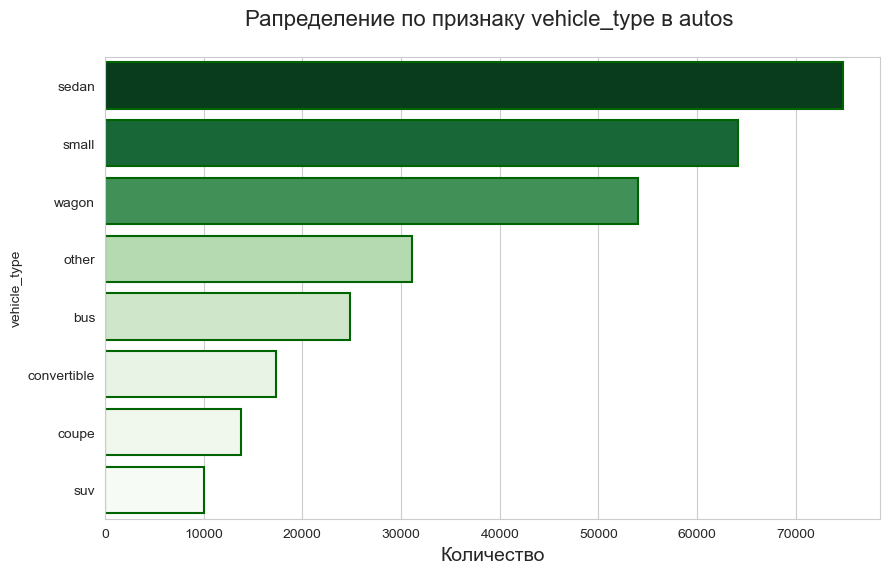

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


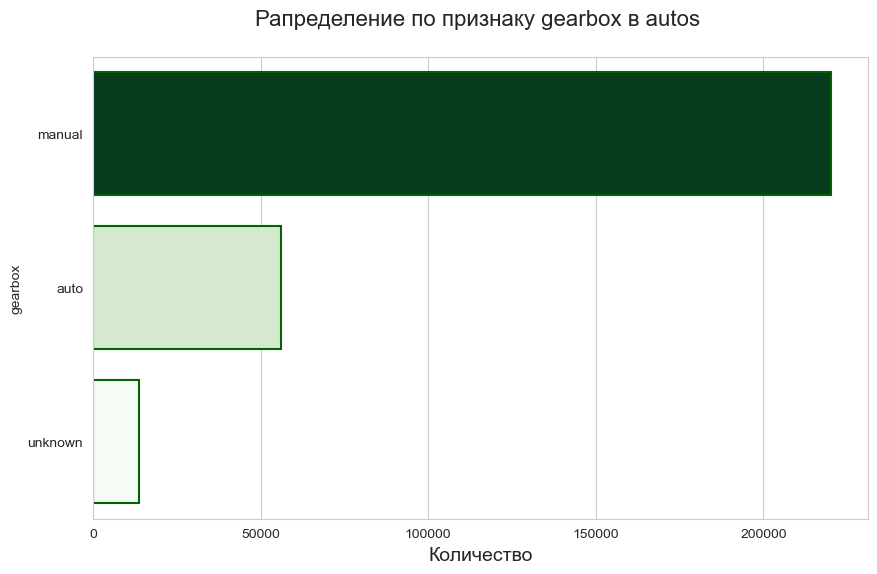

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


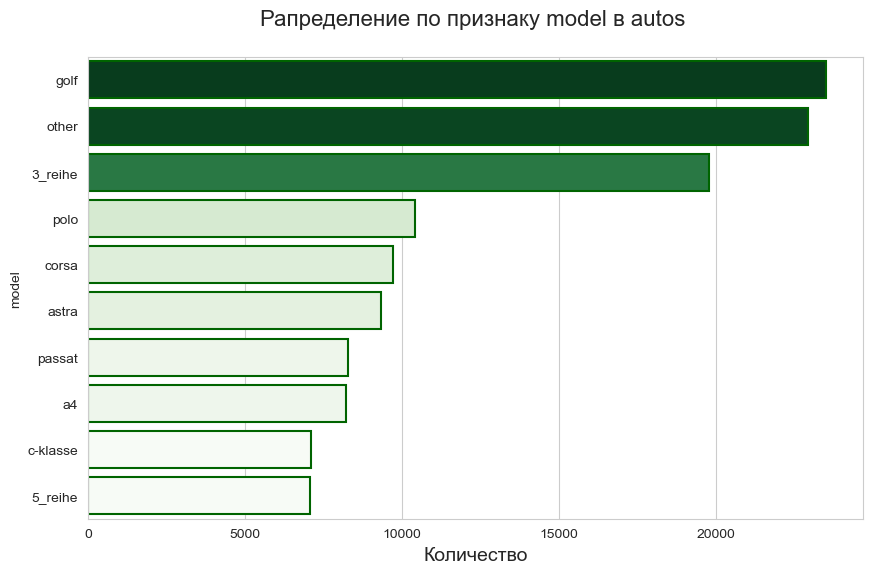

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


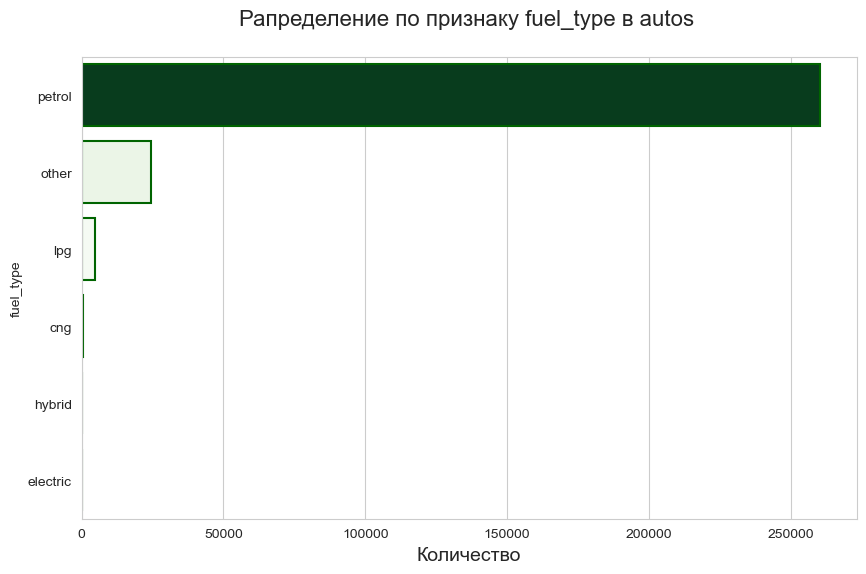

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


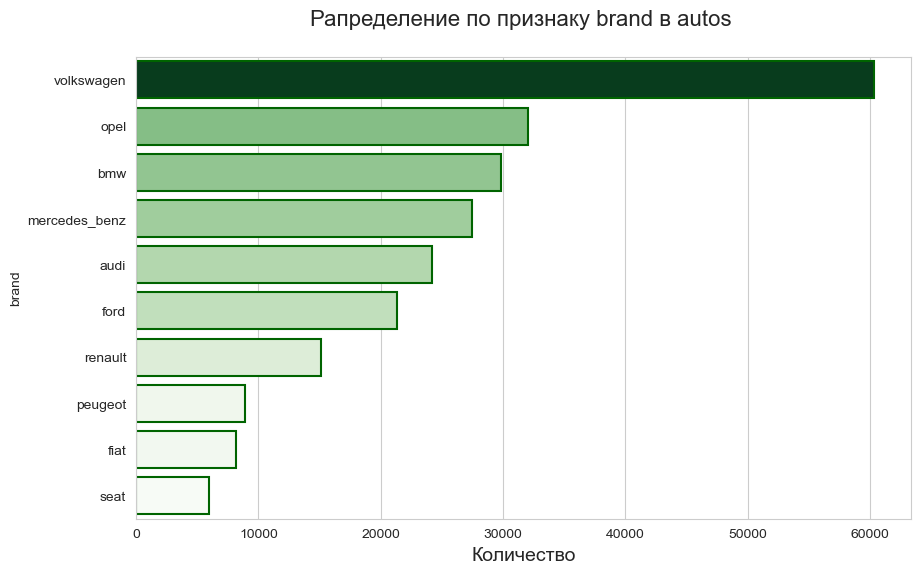

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


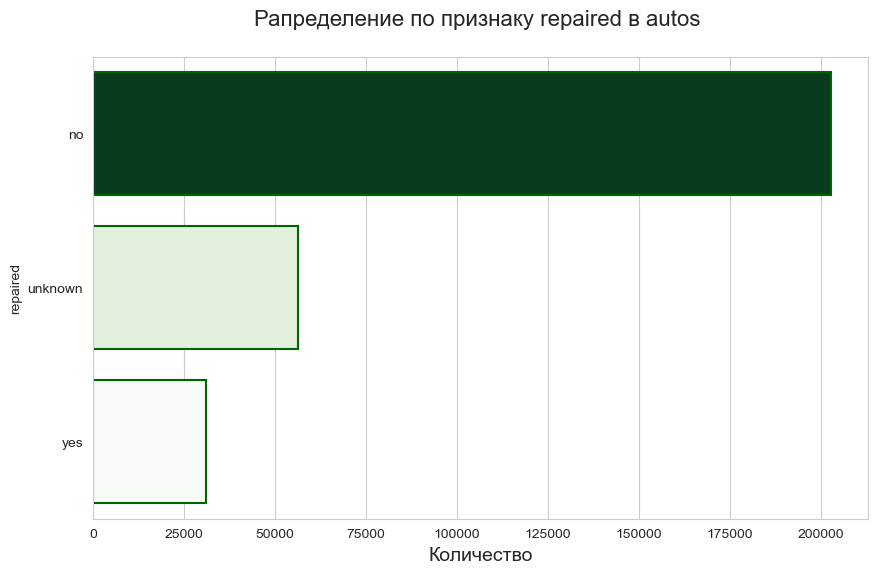

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


In [22]:
for i in autos.select_dtypes(include=['object']).columns:
    barplot_top10(autos, i, df_name='autos')
    print('>>--<< >>--<< ' * 5)

теперь посмотрим на числовые признаки:

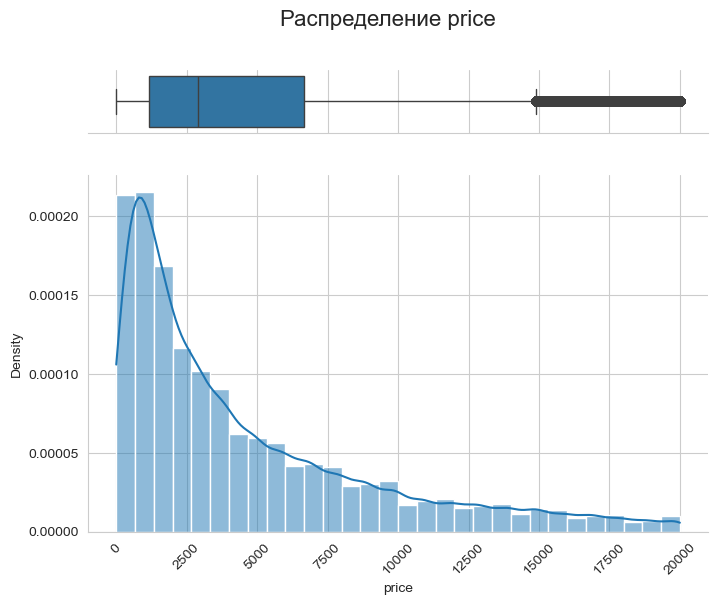

медиана: 2900.0 
среднее: 4585.5 
min: 0 
max: 20000 
верхний порог выбросов: 14897.5 
нижний порог выбросов: -7098.5 
Q1: 1150.0 
Q3: 6649.0
>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


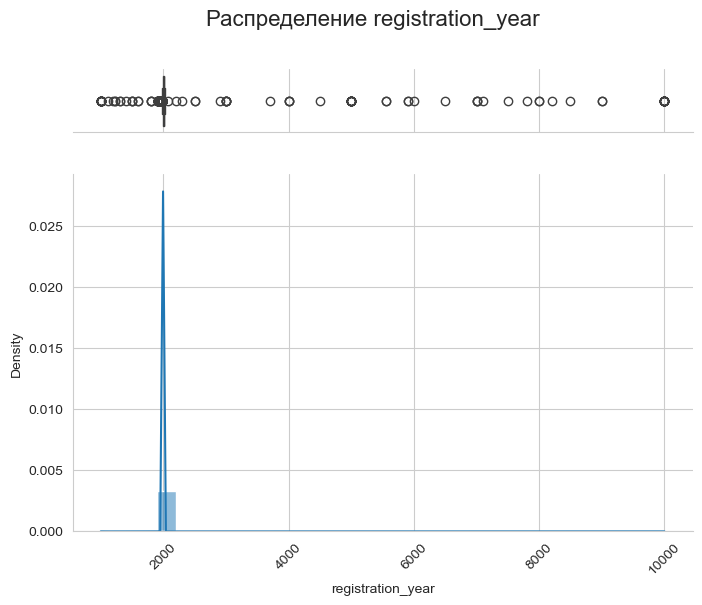

медиана: 2003.0 
среднее: 2004.1 
min: 1000 
max: 9999 
верхний порог выбросов: 2021.5 
нижний порог выбросов: 1985.5 
Q1: 1999.0 
Q3: 2008.0
>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


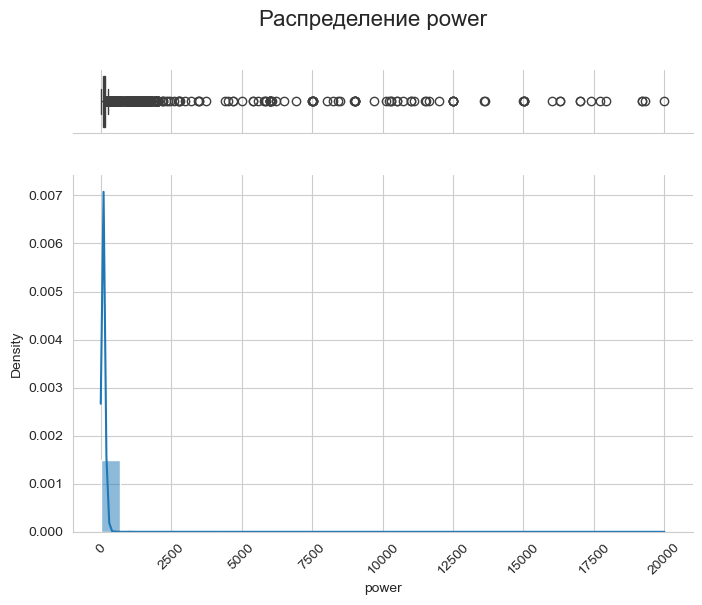

медиана: 105.0 
среднее: 112.3 
min: 0 
max: 20000 
верхний порог выбросов: 251.0 
нижний порог выбросов: -37.0 
Q1: 71.0 
Q3: 143.0
>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


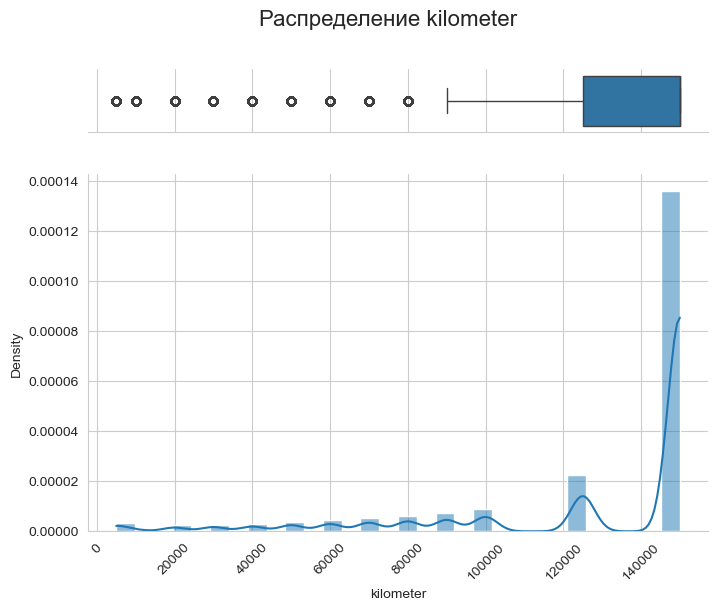

медиана: 150000.0 
среднее: 127428.0 
min: 5000 
max: 150000 
верхний порог выбросов: 187500.0 
нижний порог выбросов: 87500.0 
Q1: 125000.0 
Q3: 150000.0
>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


In [23]:
for i in autos.select_dtypes(include=[np.number]).columns:
    data_boxplot(autos, i, 'Распределение')
    print('>>--<< >>--<< ' * 5)

графики показывают, что в данных есть выбросы, которым необходимо уделить внимание:
* нулевая и неадекватно низкая цена в столбце price
* год регистрации авто: есть машины из будущего и машины из далёкого прошлого

начнём с цены: укрупним график, чтобы детальнее рассмотреть распределение дешёвых авто:

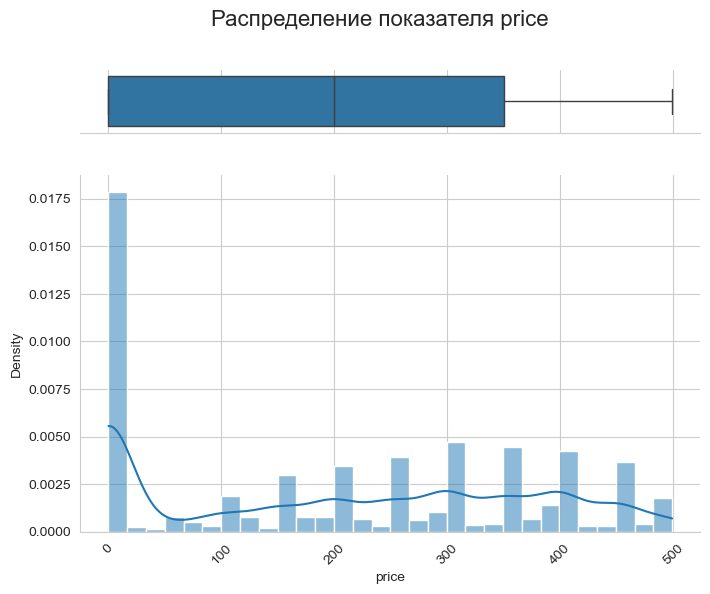

медиана: 200.0 
среднее: 204.9 
min: 0 
max: 499 
верхний порог выбросов: 875.0 
нижний порог выбросов: -525.0 
Q1: 0.0 
Q3: 350.0


In [24]:
data_boxplot(autos.query("price < 500"), 'price', 'Распределение показателя')

удалим из датасета наблюдения со значением price менее 100 евро.  
но для начала оценим изменение датасета:

In [25]:
print(f"Количество строк в срезе: {autos.query('price >= 100').shape[0]} \n"
      f"Процент от датасета: {autos.query('price >= 100').shape[0] / autos.shape[0] * 100}"
     )

Количество строк в срезе: 280987 
Процент от датасета: 96.85165844595875


теряем чуть больше 3% датасета. приемлемо.

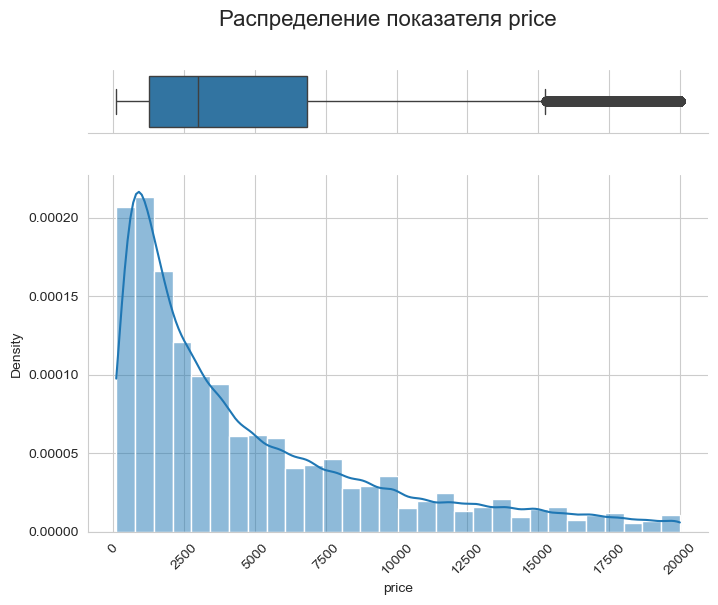

медиана: 3000.0 
среднее: 4734.4 
min: 100 
max: 20000 
верхний порог выбросов: 15250.0 
нижний порог выбросов: -7150.0 
Q1: 1250.0 
Q3: 6850.0


In [27]:
autos = autos.query('price >= 100')
data_boxplot(autos, 'price', 'Распределение показателя')

видим, что большая часть авто из датасета имеют цену 1200-1300 евро.  
рассмотрим распределение признака `registration_year`

In [28]:
autos['registration_year'].value_counts().head(15)

registration_year
2000    17845
2005    17806
1999    17086
2006    16449
2004    16036
2003    15908
2001    15907
2002    15183
2007    14388
1998    13548
2008    13114
2009    12493
1997    10916
2010     9370
2011     8488
Name: count, dtype: int64

In [29]:
autos['registration_year'].describe()

count    280987.000000
mean       2003.909035
std          59.093427
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

датасет содерижит 120 уникальных значений года регистрации, и не все эти значения адекватны. давайте рассмотрим аномальные значения. за нижний порог примем 1886 &mdash; год, когда был зарегистрирован первый автомобиль, ставший серийной моделью. т.к. у нас нет информации о дате выгрузки датасета, верхним порогом будем считать текущий 2025 год:

In [30]:
autos.loc[(autos['registration_year'] > 2016) | (autos['registration_year'] < 1886)].shape[0]

11071

In [31]:
autos.loc[
    (autos['registration_year'] > 2016) | (autos['registration_year'] < 1886),
    'registration_year'
].value_counts().head(15)

registration_year
2017    7980
2018    3014
2019      13
1000      10
5000       9
9999       8
4000       3
7000       3
1500       2
1800       2
5555       2
1234       2
1300       2
3000       2
2066       1
Name: count, dtype: int64

всего 11071 наблюдений, очевидно, ошибки ввода информации в поле "год регистрации" (возможно, пользователь ввёл 71 вместо 1971, в результате получился 7100 год). избавимся от данных с аномалиями по этому признаку. информацию о подобных ошибках следует передать заказчику: поле для ввода года регистрации следует доработать, чтобы минимизировать подобные ошибки. 

In [32]:
autos = autos.query('1886 <= registration_year <= 2016')
print('Размер датасета:', autos.shape)

Размер датасета: (269916, 10)


In [33]:
autos['power'].value_counts().head(15)

power
0      24606
75     16805
150    11323
60     11132
140    10115
90      9881
101     9726
116     9625
105     8156
170     8111
136     5441
125     5412
102     5025
163     4935
143     4443
Name: count, dtype: int64

In [34]:
autos['power'].describe()

count    269916.000000
mean        114.169482
std         190.957063
min           0.000000
25%          75.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

укрупним график, чтобы рассмотреть подробнее автомобили с заявленными низкими мощностями:

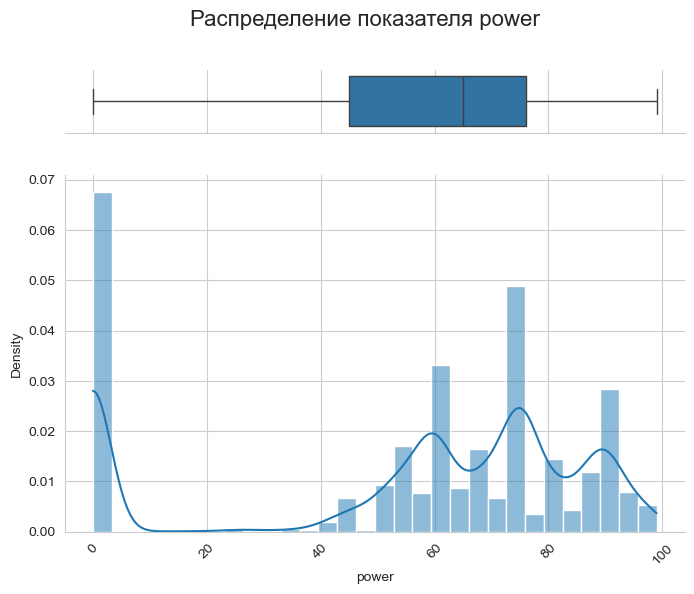

медиана: 65.0 
среднее: 55.4 
min: 0 
max: 99 
верхний порог выбросов: 122.5 
нижний порог выбросов: -1.5 
Q1: 45.0 
Q3: 76.0


In [36]:
data_boxplot(autos.query("power < 100"), 'power', 'Распределение показателя')

теперь сделаем то же самое, но для верхней границы:

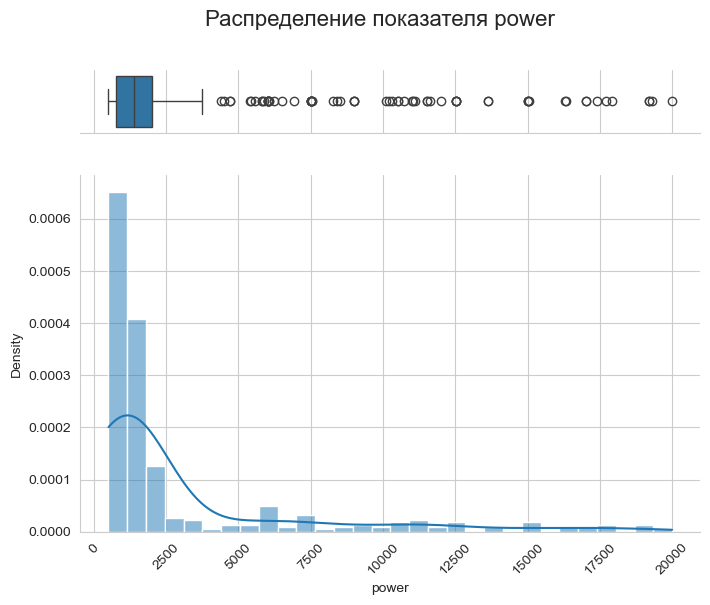

медиана: 1378.5 
среднее: 3023.4 
min: 504 
max: 20000 
верхний порог выбросов: 3897.5 
нижний порог выбросов: -1133.7 
Q1: 753.0 
Q3: 2010.8


In [37]:
data_boxplot(autos.query("power > 500"), 'power', 'Распределение показателя')

посмотрим, сколько наблюдений останется за рамками (40, 600):

In [38]:
autos.loc[(autos['power'] > 600) | (autos['power'] < 40)].shape[0]

25843

так же, как и в случае с голом регистрации, не будем прибегать к замене аномалий заглушкой, срежем аномальные наблюдения:

In [39]:
autos = autos.query('40 <= power <= 600')
print('Размер датасета:', autos.shape)

Размер датасета: (244073, 10)


теперь выполним квантильные построения и посмотрим на корреляцию, чтобы лучше понять, как распределены данные

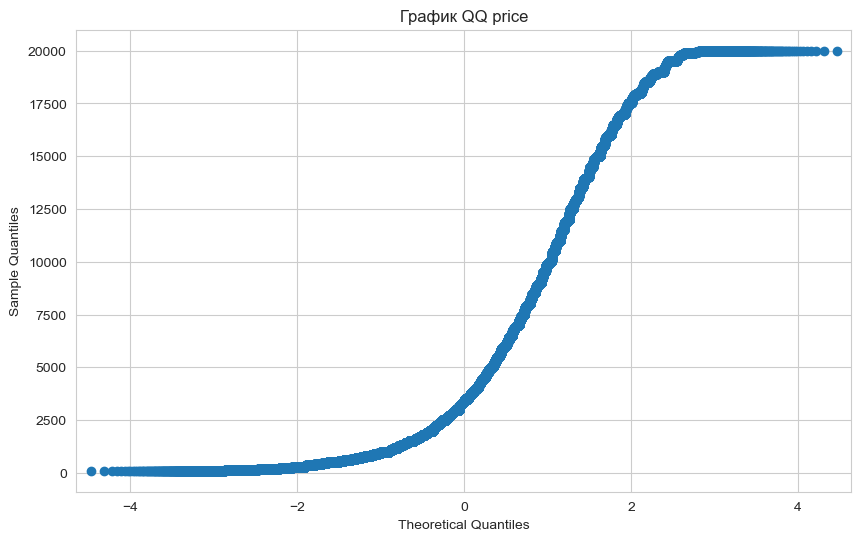

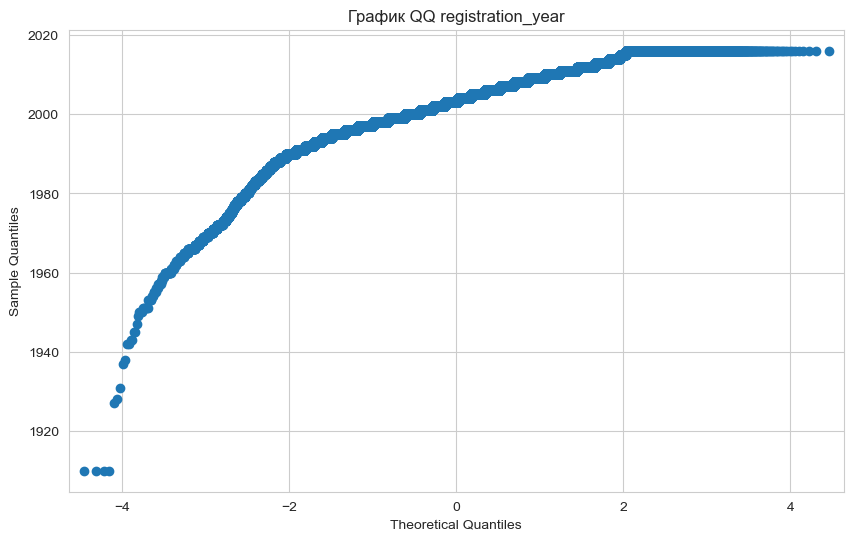

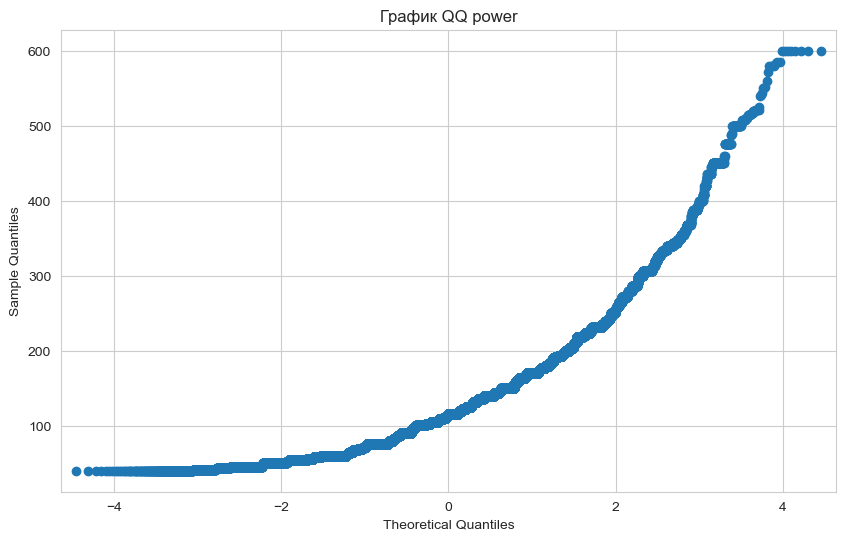

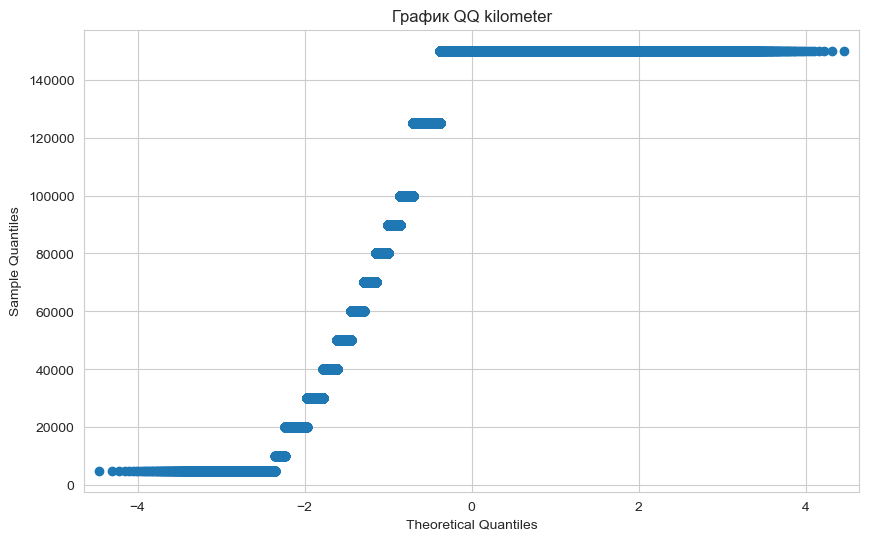

In [40]:
num_feature = autos.select_dtypes(include=[np.number]).columns

for i in num_feature:
    sm.qqplot(autos[i])
    plt.title(f'График QQ {i}')
    plt.show()

теоретические квантили указывают на бимодальное и экспоненциальное распределение.<br>
выполним проверку на мультиколлинеарность.

In [42]:
X = sm.add_constant(autos.select_dtypes(include=[np.number]))

# расчёт VIF для каждого предиктора
print('расчёт VIF для каждого предиктора')
print()
VIFs = pd.DataFrame()
VIFs['Variable'] = X.columns
VIFs['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(VIFs)

расчёт VIF для каждого предиктора

            Variable            VIF
0              const  138772.708916
1              price       2.223462
2  registration_year       1.405133
3              power       1.598305
4          kilometer       1.400029


высокие значения VIF указывают на потенциальные проблемы с мультиколлинеарностью: обычно значение VIF выше 5 требует внимания, а выше 10 — серьезного рассмотрения изменений в модели. в нашем случае можно работать без удаления признаков.<br>

построим матрицу корреляции числовых признаков:

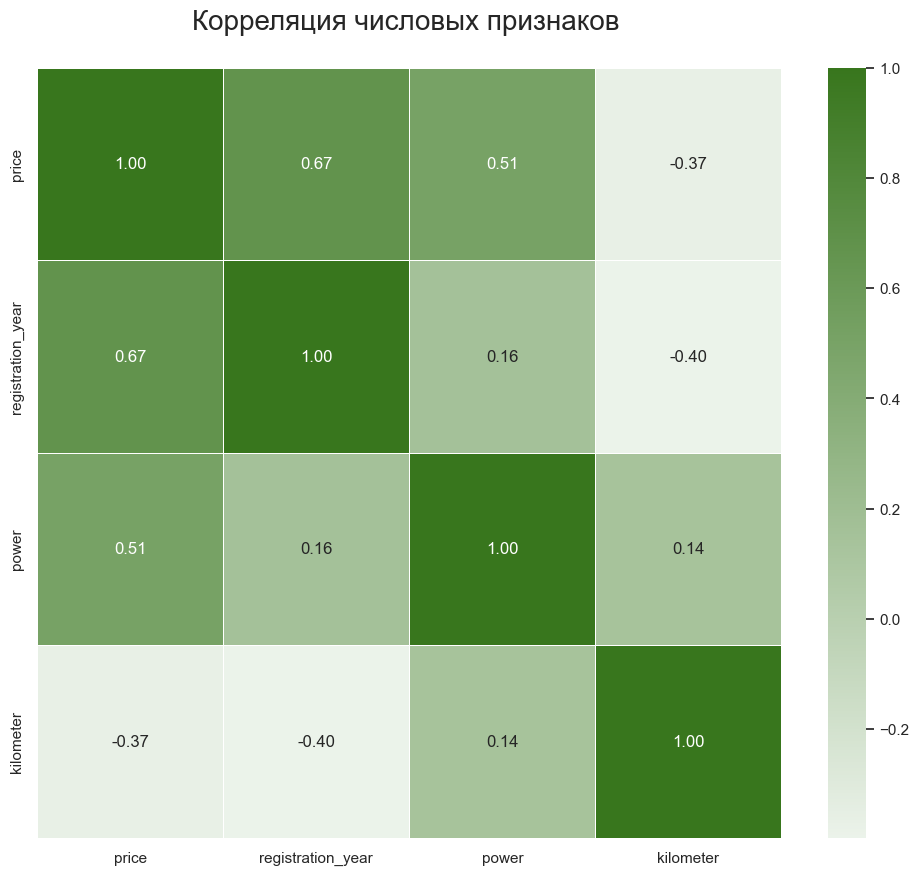

In [43]:
green_cmap = sns.light_palette("#38761d", as_cmap=True)
sns.set(rc={"figure.figsize": (12, 10)})
sns.heatmap(autos.select_dtypes(include=['number'])
            .corr('spearman'), 
            annot=True, fmt='.2f', 
            cmap=green_cmap, 
            linewidths=0.5
           )
plt.title('Корреляция числовых признаков \n', fontsize=20)
plt.show()

в датасете присутствует отрицательная, слабо отрицательная и слабоположительная корреляция признаков.  
проверим на корреляцию категориальные признаки:

interval columns not set, guessing: ['price', 'registration_year', 'power', 'kilometer']


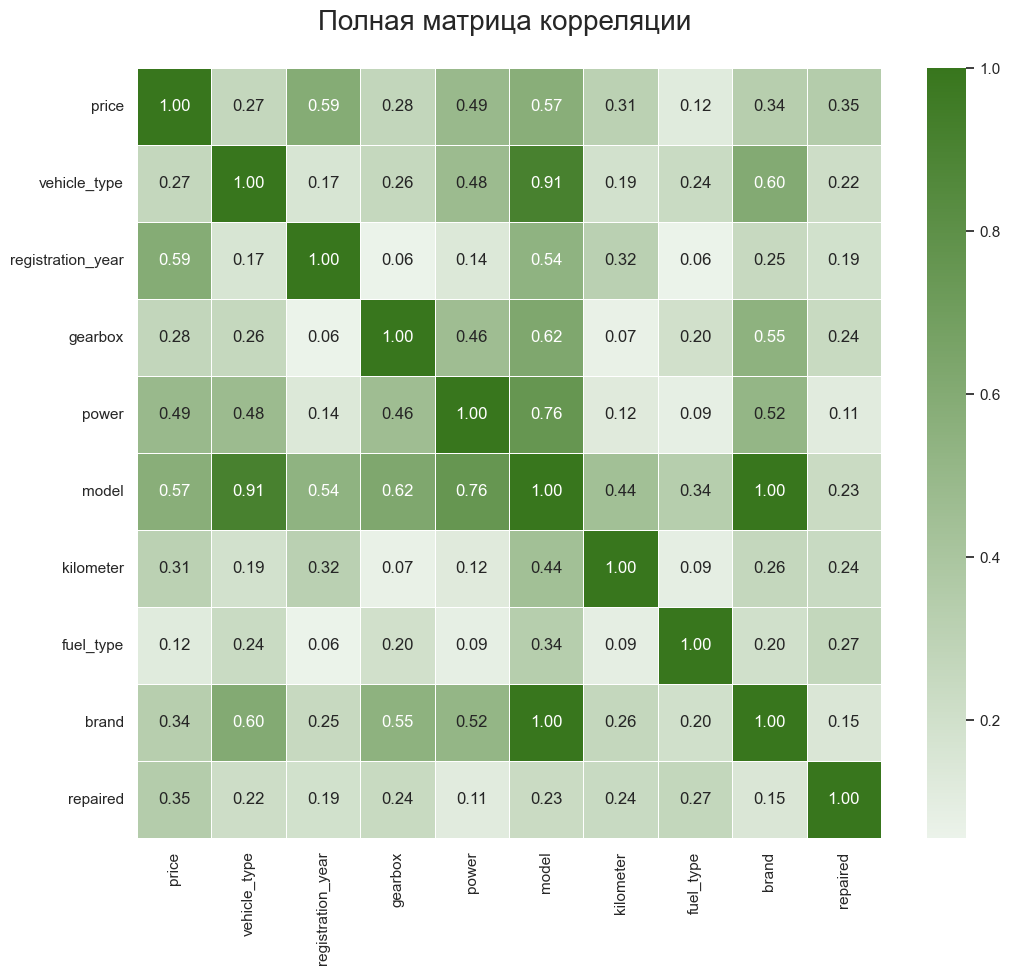

In [44]:
matrix_corr = autos.phik_matrix()

sns.heatmap(matrix_corr, 
            annot=True, fmt='.2f', 
            cmap=green_cmap, 
            linewidths=0.5
           )
plt.title('Полная матрица корреляции \n', fontsize=20)
plt.show()

матрица обнаружила сильную корреляцию между признаками `model` и `vehicletype`, `model` и `brand`.<br> 
для устранения проблемы будет полезно объединить и закрдировать `model` и `brand`

In [45]:
autos_temp = autos.copy()
autos_temp['brand_model'] = autos_temp['brand'].astype(str) + ' ' + autos_temp['model'].astype(str)
autos_temp['model_code'] = autos_temp['brand_model'].map(autos_temp.groupby('brand_model').size()) / \
                     autos_temp['brand'].map(autos_temp.groupby('brand').size())

autos_temp.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,brand_model,model_code
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,unknown,jeep grand,0.381853
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,volkswagen golf,0.391341
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no,skoda fabia,0.385989
5,650,sedan,1995,manual,102,3_reihe,150000,petrol,bmw,yes,bmw 3_reihe,0.551763
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no,peugeot 2_reihe,0.479861


In [46]:
autos_final = autos_temp.drop(['brand_model', 'model', 'brand'], axis=1)

autos_final.head()

,price,vehicle_type,registration_year,gearbox,power,kilometer,fuel_type,repaired,model_code
2,9800,suv,2004,auto,163,125000,petrol,unknown,0.381853
3,1500,small,2001,manual,75,150000,petrol,no,0.391341
4,3600,small,2008,manual,69,90000,petrol,no,0.385989
5,650,sedan,1995,manual,102,150000,petrol,yes,0.551763
6,2200,convertible,2004,manual,109,150000,petrol,no,0.479861


построим матрицу корреляции ещё раз:

interval columns not set, guessing: ['price', 'registration_year', 'power', 'kilometer', 'model_code']


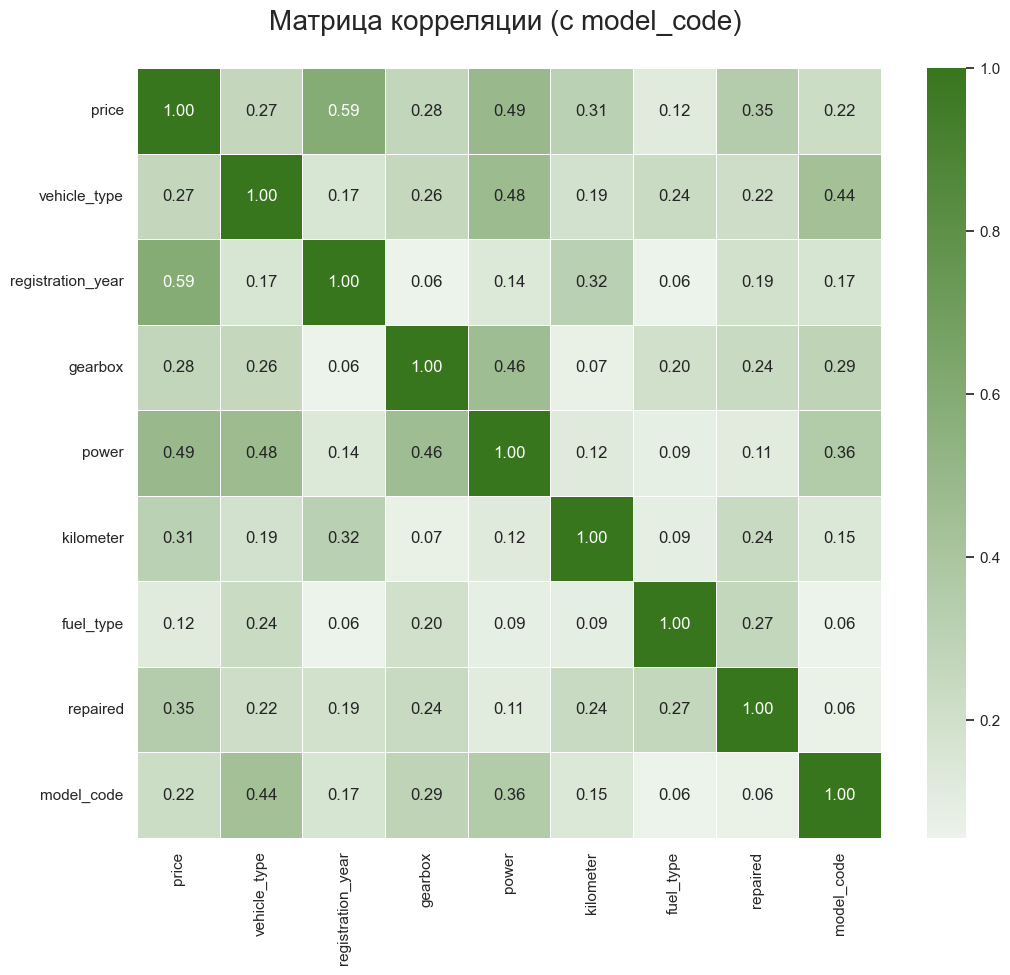

In [47]:
matrix_corr = autos_final.phik_matrix()

sns.heatmap(matrix_corr, 
            annot=True, fmt='.2f', 
            cmap=green_cmap, 
            linewidths=0.5
           )
plt.title('Матрица корреляции (с model_code) \n', fontsize=20)
plt.show()

отлично, нам удалось избавить от мультиколлинеарности в категориальных переменных.  

**промежуточный вывовод**.<br>

* в датасете машин на продажу преобладают седаны с механической коробкой передач на бензине; ниболее поруллярная марка &mdash; wolkswagen.
* данные зашумлены, выражена несбалансированность, теоретические квантили указывают на бимодальное распределение, экспоненциальное распределение.

## Подготовка к моделированию
### подготовка данных перед сборкой пайплайна

In [48]:
X = autos.drop(columns = ['price'], axis =1)
y = autos['price']

ohe_columns = list(X.select_dtypes(include='object').columns)
num_columns = X.select_dtypes(include=[np.number]).columns

for col in ohe_columns:
    X[col] = X[col].astype("category")

print(f"OHE columns:\n{ohe_columns} \n\n"
      f"NUM columns:\n{num_columns} \n\n"
      f"X shape:{X.shape} \ny shape:{y.shape} \n\n"
      f"Columns:\n{X.columns}"
     )

X.info()

OHE columns:
['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired'] 

NUM columns:
Index(['registration_year', 'power', 'kilometer'], dtype='object') 

X shape:(244073, 9) 
y shape:(244073,) 

Columns:
Index(['vehicle_type', 'registration_year', 'gearbox', 'power', 'model',
       'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 244073 entries, 2 to 354368
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   vehicle_type       244073 non-null  category
 1   registration_year  244073 non-null  int64   
 2   gearbox            244073 non-null  category
 3   power              244073 non-null  int64   
 4   model              244073 non-null  category
 5   kilometer          244073 non-null  int64   
 6   fuel_type          244073 non-null  category
 7   brand              244073 non-null  category
 8   repaired           244

### сборка пайплайна

In [49]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        
        (
        'ord',
        OrdinalEncoder(
            handle_unknown='use_encoded_value', 
            unknown_value=np.nan
        ))
    
         ,
        (
        'simple_Imputer',
        SimpleImputer( missing_values=np.nan, strategy='most_frequent')
    )
    ])



data_preprocessor = ColumnTransformer([
    ('ohe', ord_pipe, ohe_columns),
    ('num', MinMaxScaler(), num_columns)
], remainder='passthrough')

data_preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ord',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan)),
                                                 ('simple_Imputer',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['vehicle_type', 'gearbox', 'model',
                                  'fuel_type', 'brand', 'repaired']),
                                ('num', MinMaxScaler(),
                                 Index(['registration_year', 'power', 'kilometer'], dtype='object'))])

### разделение выборок и определение оптимальной модели

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=RANDOM_STATE
                                                   )

X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.25, 
                                                  random_state=RANDOM_STATE
                                                 )

* test_size=0.2 — 20% данных будут отведены под тестовую выборку, а 80% — под тренировочную.
* test_size=0.25 (второй этап) — 25% от тренировочных данных выделяются для валидации, что составляет 20% от всего набора данных.

размеры выборок:
* тренировочная: 60% данных.
* валидационная: 20% данных.
* тестовая: 20% данных.

**промежуточный вывод**: <br>
потготовили данные, закодировали их OrdinalEncoder, провели разделение выборок 

по ТЗ от нас ожидают обучения и оценки нескольких моделей, среди них ожидают:
* LightGBM
* любую не бустинговую модель (возьмём RandomForestRegressor)

## Анализ моделей

In [51]:
lgbm = Pipeline(steps=[
            ('preprocessor', data_preprocessor),
            ('model', LGBMRegressor(random_state=RANDOM_STATE, verbose = -1))
        ])


rfr = Pipeline(steps=[
            ('preprocessor', data_preprocessor),
            ('model', RandomForestRegressor(random_state=RANDOM_STATE))
        ])

cat = Pipeline(steps=[
            ('preprocessor', data_preprocessor),
            ('model', CatBoostRegressor(random_state=RANDOM_STATE, verbose = 0))
        ])

xgb = Pipeline(steps=[
            ('preprocessor', data_preprocessor),
            ('model', XGBRegressor(random_state=RANDOM_STATE))
])

### оценка производительности
напишем функцию для оценки производительности моделей:

In [52]:
def evaluate_model(model, X_train, y_train, X_val, y_val):
    results = {}

    # время обучения
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    results['train_time'] = end - start

    # время предсказания
    start = time.time()
    y_pred = model.predict(X_val)
    end = time.time()
    results['predict_time'] = end - start

    # RMSE
    results['rmse'] = np.sqrt(mean_squared_error(y_val, y_pred))

    return results

соберём оценки:

In [53]:
results = {}
results['lgbm'] = evaluate_model(lgbm, X_train, y_train, X_val, y_val)
results['rf']   = evaluate_model(rfr, X_train, y_train, X_val, y_val)
results['cat']  = evaluate_model(cat, X_train, y_train, X_val, y_val)
results['xgb']  = evaluate_model(xgb, X_train, y_train, X_val, y_val)

C:\Users\JPB\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


для удобства сравнения соберём полученные данные в одну таблицу:

In [54]:
model_compare = pd.DataFrame(results).T.reset_index()
model_compare = model_compare.rename(columns={'index': 'model'})

model_compare

,model,train_time,predict_time,rmse
0,lgbm,0.582840,0.102985,1701.834028
1,rf,23.675954,1.054713,1693.597865
2,cat,8.537356,0.146208,1624.257799
3,xgb,0.390259,0.079702,1644.385371


### настройка гиперпараметров

In [55]:
def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500), # урезан верхний порог, иначе очень долго считает
        'depth': trial.suggest_int('depth', 2, 8),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-9, 10.0, log=True),
        'verbose': 0,
    }
    
    model = Pipeline(steps=[
            ('preprocessor', data_preprocessor),
            ('model', CatBoostRegressor(**params, random_state=RANDOM_STATE))
        ])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    return rmse


study_catboost = optuna.create_study(direction='minimize')
study_catboost.optimize(objective_catboost, n_trials=10) # уменьшено количество попыток


cat_param = study_catboost.best_params
cat_score = study_catboost.best_value
print("Лучшие hyperparameters для CatBoost:", study_catboost.best_params)
print("Лучший RMSE score для CatBoost:", study_catboost.best_value)

[I 2026-02-16 09:58:56,798] A new study created in memory with name: no-name-c8188227-37a0-46b1-9188-5f3c19414fc5
[I 2026-02-16 09:58:59,884] Trial 0 finished with value: 2171.190473752888 and parameters: {'iterations': 218, 'depth': 8, 'learning_rate': 0.009576682669315113, 'l2_leaf_reg': 0.011781923570697978, 'random_strength': 0.3144451679823008}. Best is trial 0 with value: 2171.190473752888.
[I 2026-02-16 09:59:02,227] Trial 1 finished with value: 1788.9017643511952 and parameters: {'iterations': 252, 'depth': 4, 'learning_rate': 0.09130619484877772, 'l2_leaf_reg': 0.1079004725533772, 'random_strength': 7.727481489800871e-08}. Best is trial 1 with value: 1788.9017643511952.
[I 2026-02-16 09:59:04,516] Trial 2 finished with value: 4494.331139113357 and parameters: {'iterations': 371, 'depth': 2, 'learning_rate': 0.0002204529813548971, 'l2_leaf_reg': 0.0016825845401066378, 'random_strength': 0.00022427450254550865}. Best is trial 1 with value: 1788.9017643511952.
[I 2026-02-16 09:59

Лучшие hyperparameters для CatBoost: {'iterations': 470, 'depth': 6, 'learning_rate': 0.0426849608463477, 'l2_leaf_reg': 0.1408996320718087, 'random_strength': 2.977376288223533e-08}
Лучший RMSE score для CatBoost: 1724.3032571223914


In [56]:
def objective_xgboost(trial):
    # Подбираемые гиперпараметры
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500), 
        'max_depth': trial.suggest_int('max_depth', 2, 8),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    }

    # Модель в пайплайне
    model = Pipeline(steps=[
        ('preprocessor', data_preprocessor),
        ('model', XGBRegressor(**params, random_state=RANDOM_STATE, verbosity=0))
    ])
    
    # Обучение
    model.fit(X_train, y_train)
    
    # Предсказание и RMSE
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    
    return rmse

study_xgboost = optuna.create_study(direction='minimize')
study_xgboost.optimize(objective_xgboost, n_trials=10)

xgb_param = study_xgboost.best_params
xgb_score = study_catboost.best_value
print("Лучшие hyperparameters для XGBoost:", study_xgboost.best_params)
print("Лучший RMSE score для XGBoost:", study_xgboost.best_value)

[I 2026-02-16 09:59:47,772] A new study created in memory with name: no-name-3104d26e-ebba-4374-823a-5f5321723d36
[I 2026-02-16 09:59:48,505] Trial 0 finished with value: 4245.543545884319 and parameters: {'n_estimators': 228, 'max_depth': 5, 'learning_rate': 0.0006100069645998377, 'subsample': 0.9682953566366534}. Best is trial 0 with value: 4245.543545884319.
[I 2026-02-16 09:59:49,454] Trial 1 finished with value: 1775.6579766385191 and parameters: {'n_estimators': 227, 'max_depth': 5, 'learning_rate': 0.03379269520594315, 'subsample': 0.9458143876617728}. Best is trial 1 with value: 1775.6579766385191.
[I 2026-02-16 09:59:50,996] Trial 2 finished with value: 4116.496568685561 and parameters: {'n_estimators': 321, 'max_depth': 8, 'learning_rate': 0.0005170477804918659, 'subsample': 0.8689989959849562}. Best is trial 1 with value: 1775.6579766385191.
[I 2026-02-16 09:59:51,805] Trial 3 finished with value: 4528.92724604845 and parameters: {'n_estimators': 244, 'max_depth': 5, 'learni

Лучшие hyperparameters для XGBoost: {'n_estimators': 426, 'max_depth': 5, 'learning_rate': 0.07698343125596534, 'subsample': 0.9798715220651304}
Лучший RMSE score для XGBoost: 1647.833046761716


In [57]:
def objective_lgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 2, 8),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 6, 32),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'metric': 'rmse',
    }

    model = Pipeline(steps=[
            ('preprocessor', data_preprocessor),
            ('model', LGBMRegressor(**params, random_state=RANDOM_STATE, verbose = -1))
        ])
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_pred, y_val))
    
    return rmse


study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=10)
             

lgbm_param = study_lgbm.best_params
lgbm_score = study_lgbm.best_value
print("Лучшие hyperparameters для LGBM:", study_lgbm.best_params)
print("Лучший RMSE score для LGBM:", study_lgbm.best_value)

[I 2026-02-16 10:00:05,556] A new study created in memory with name: no-name-543e78bf-114d-4e3a-a6ae-923a9c17b73b
C:\Users\JPB\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2026-02-16 10:00:06,197] Trial 0 finished with value: 1804.5672619582567 and parameters: {'n_estimators': 171, 'max_depth': 5, 'learning_rate': 0.03851340119677176, 'num_leaves': 23, 'subsample': 0.585253582025463}. Best is trial 0 with value: 1804.5672619582567.
C:\Users\JPB\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2026-02-16 10:00:06,802] Trial 1 finished with value: 4430.290952564389 and parameters: {'n_estimators': 112, 'max_depth': 2, 'learning_rate': 0.0009826303479851164, 'num_leaves': 6, 'subsample': 0.6070418675791379}. Best is trial 0 wit

Лучшие hyperparameters для LGBM: {'n_estimators': 171, 'max_depth': 5, 'learning_rate': 0.03851340119677176, 'num_leaves': 23, 'subsample': 0.585253582025463}
Лучший RMSE score для LGBM: 1804.5672619582567


In [58]:
def objective_rf(trial):

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 5),
    }


    model = Pipeline(steps=[
            ('preprocessor', data_preprocessor),
            ('model', RandomForestRegressor(**params, random_state=RANDOM_STATE))
            ])
    model.fit(X_train, y_train)
    

    y_pred = model.predict(X_test)
    

    rmse = np.sqrt(mean_squared_error(y_pred, y_val))
    
    return rmse


study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials=10)

rf_param = study_rf.best_params
rf_score = study_rf.best_value
print("Лучшие hyperparameters для RandomForestRegressor:", study_rf.best_params)
print("Лучший RMSE score для RandomForestRegressor:", study_rf.best_value)

[I 2026-02-16 10:00:24,772] A new study created in memory with name: no-name-81f9a3a0-d72a-47e9-b9b1-9272f2c9dedb
[I 2026-02-16 10:00:44,574] Trial 0 finished with value: 5915.469402215613 and parameters: {'n_estimators': 421, 'max_depth': 3, 'min_samples_split': 3}. Best is trial 0 with value: 5915.469402215613.
[I 2026-02-16 10:01:15,657] Trial 1 finished with value: 6198.254918822362 and parameters: {'n_estimators': 404, 'max_depth': 6, 'min_samples_split': 2}. Best is trial 0 with value: 5915.469402215613.
[I 2026-02-16 10:01:26,421] Trial 2 finished with value: 6055.691193853045 and parameters: {'n_estimators': 199, 'max_depth': 4, 'min_samples_split': 3}. Best is trial 0 with value: 5915.469402215613.
[I 2026-02-16 10:01:40,496] Trial 3 finished with value: 5785.125735597316 and parameters: {'n_estimators': 428, 'max_depth': 2, 'min_samples_split': 4}. Best is trial 3 with value: 5785.125735597316.
[I 2026-02-16 10:02:12,476] Trial 4 finished with value: 6137.8464415477265 and pa

Лучшие hyperparameters для RandomForestRegressor: {'n_estimators': 428, 'max_depth': 2, 'min_samples_split': 4}
Лучший RMSE score для RandomForestRegressor: 5785.125735597316


In [59]:
scores_df = pd.DataFrame({
    'model': ['catboost', 'lgbm', 'xgb', 'rf'],
    'RMSE': [cat_score, lgbm_score, xgb_score, rf_score]
})

scores_df = scores_df.sort_values(by='RMSE', ascending=True).reset_index(drop=True)

print('оценки моделей')
scores_df

оценки моделей


,model,RMSE
0,catboost,1724.303257
1,xgb,1724.303257
2,lgbm,1804.567262
3,rf,5785.125736


**промежуточный вывод**. <br>
не все модели продемонстрировали лучший результат при подборе параметров, однако в условиях данного исследования мы ьыли вынуждены ввести ограничения. при большем количестве итераций и повторов каждая из использованных выше моделей, скорее всего, даст более приемлемые результаты.

In [60]:
lgbm_model = Pipeline(steps=[
    ('preprocessor', data_preprocessor),
    ('model', LGBMRegressor(**lgbm_param, random_state=RANDOM_STATE, verbose=-1, boosting_type='gbdt'))
])

cat_model = Pipeline(steps=[
    ('preprocessor', data_preprocessor),
    ('model', CatBoostRegressor(**cat_param, random_state=RANDOM_STATE, verbose=0))
])

xgb_model = Pipeline(steps=[
    ('preprocessor', data_preprocessor),
    ('model', XGBRegressor(**xgb_param, random_state=RANDOM_STATE, verbosity=0))
])

rf_model = Pipeline(steps=[
    ('preprocessor', data_preprocessor),
    ('model', RandomForestRegressor(**rf_param, random_state=RANDOM_STATE))
])

In [61]:
val_results = {}
val_results['lgbm'] = evaluate_model(lgbm_model, X_train, y_train, X_val, y_val)
val_results['cat']  = evaluate_model(cat_model, X_train, y_train, X_val, y_val)
val_results['xgb']  = evaluate_model(xgb_model, X_train, y_train, X_val, y_val)
val_results['rf']   = evaluate_model(rf_model, X_train, y_train, X_val, y_val)

C:\Users\JPB\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [62]:
val_compare = pd.DataFrame(val_results).T.reset_index()
val_compare = val_compare.rename(columns={'index': 'model'})

val_compare

,model,train_time,predict_time,rmse
0,lgbm,0.465034,0.114764,1804.567262
1,cat,3.839775,0.124907,1724.303257
2,xgb,0.970349,0.092619,1647.833047
3,rf,14.782462,0.300865,3233.638364


на валидации модель lgbm продемонстрировада наиболее оптимальный результат, если смотреть в разрезе баланса качества и скорости: самый бытрый CatBoost на третьем месте по rmse, самый точный xgb требует больше всего времени на обучение и предсказание

### тестирование

In [63]:
%%time

model = Pipeline(steps=[
            ('preprocessor', data_preprocessor),
            ('model', LGBMRegressor(**lgbm_param, random_state=RANDOM_STATE, verbose = -1))
        ])

# обучение
start = time.time()
model.fit(X_train, y_train)
end = time.time()
train_time = end - start

# предсказание
start_pred = time.time()
y_pred = model.predict(X_test)
end_pred = time.time()
pred_time = end_pred - start_pred

rmse = np.sqrt(mean_squared_error(y_pred, y_test))

print("Лучшая модель:", rmse)

Лучшая модель: 1776.0708123560003
CPU times: total: 4.34 s
Wall time: 600 ms


C:\Users\JPB\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


**промежуточный вывод** <br>
в условиях заданных ограничений все исследуемые модели продемонстрировали примерно одинаковые качественные результаты.  
lgbm продемонстрировада наиболее оптимальный результат, если смотреть в разрезе баланса качества и скорости

## Вывод

выполнили полный цикл работы с данными в ходе анализа и подготовки данных для моделирования:

1. загрузка и предобработка данных: <br>
    * ✅ выявили и устранили неинформативные признаки, дубликаты, стандартизовали названия признаков.
    * ✅ выявили несбалансированность данных, а также наличие бимодального и экспоненциального распределений, в результате чего провели дополнительную обработку.


2. анализ и подготовка признаков:
    * ✅ применили методы нормализации и кодирования для обработки количественных выбросов и чувствительности RMSE к квантилям.
    * ✅ разделили данные на целевой и обучаюшие признаки


3. построение моделей и оценка эффективности:
    * ✅ провели перекрёстную проверку моделей с подбором гиперпараметров.
    * ✅ протестировали несколько моделей, каждая из которых показала приемлемые результаты.
    * ✅ установили, что LGBM демонстрирует наилучший результат по времени обучения, времени и качеству предсказания

**рекомендации**:<br>
для выполнения требований заказчика в условиях заданных гиперпараметров (высокое качество предсказания, минимальное время обучения и предсказания) оптимален lgbm.